In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torchsummary


In [3]:
import os
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

In [4]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Ensure reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device : cuda


In [5]:
# Define paths for train and test datasets
train_folder_path = "/kaggle/input/assignment-4/Assignment_4/Train/Train_data"
test_folder_path = "/kaggle/input/assignment-4/Assignment_4/Test/Test_data"

# Function to combine images from multiple folders into a single list
def combine_folders(folder_paths):
    combined_dataset = []
    for folder_path in folder_paths:
        files = os.listdir(folder_path)
        # Filter out files that are not images
        image_files = [file for file in files if file.lower().endswith((".jpg", ".jpeg", ".png"))]
        file_paths = [os.path.join(folder_path, file) for file in image_files]
        combined_dataset.extend(file_paths)
    return combined_dataset


# Combine train and test folders
combined_dataset = combine_folders([train_folder_path, test_folder_path])


In [6]:
def count_images_in_folder(folder_path):
    # Initialize a counter for the number of images
    num_images = 0
    
    # Iterate over the files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file has an image extension
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            num_images += 1
    
    return num_images

In [7]:
print("Number of images in combined dataset:", len(combined_dataset))


Number of images in combined dataset: 10015


In [8]:
import os
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_name = self.file_paths[idx]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to (256, 256) for U-Net models
    transforms.RandomRotation(degrees=30),   # Rotate images randomly by up to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),     # Randomly flip images vertically with a probability of 0.5
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create a dataset from the combined list of files
train_dataset = CustomDataset(file_paths=combined_dataset, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)


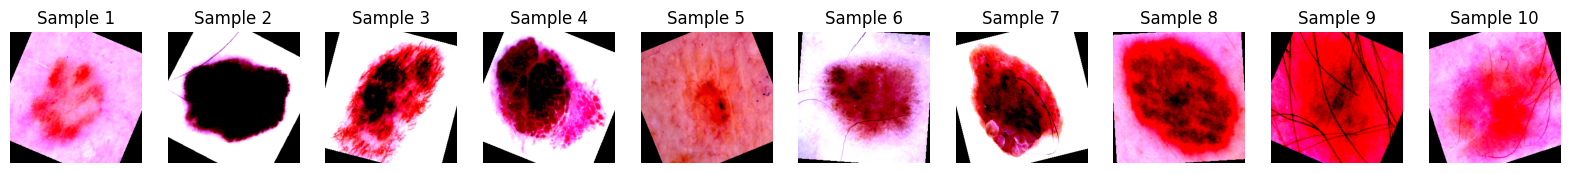

In [9]:
import matplotlib.pyplot as plt

# Visualize 5 sample images from the dataset
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    sample_image = train_dataset[i+8000]  # Get i-th image from the dataset
    axes[i].imshow(sample_image.permute(1, 2, 0))  # Permute dimensions for visualization
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i+1}")

plt.show()

In [10]:
# Define encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x

In [11]:
# Define decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))  # Apply sigmoid activation for pixel values between [0, 1]
        return x

In [12]:
# Define VQ layer
class VectorQuantization(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantization, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)

    def forward(self, inputs):
        # Flatten input
        input_shape = inputs.shape
        flat_inputs = inputs.view(-1, self.embedding_dim)
        #print(f"flattening while quant {flat_inputs.shape}")

        # Compute distances between input and embeddings
        distances = torch.sum(flat_inputs**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(flat_inputs, self.embedding.weight.t())

        # Find closest embedding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        #print(f"encoded indices : {encoding_indices.shape}")
        #print(encoding_indices)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss calculation
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()

        return quantized, loss, encoding_indices

In [13]:
# Define VQ-VAE model
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        # Define encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
        # Define VQ-VAE components
        self.vq_layer = VectorQuantization(num_embeddings, embedding_dim, commitment_cost)
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        # Encode input
        z = self.encoder(x)
        # Quantize latent space
        quantized_z, quantization_loss,_ = self.vq_layer(z)
        #print(f"Quantized output {quantized_z.shape}")
        # Decode quantized latent space
        x_recon = self.decoder(quantized_z)
        # Reconstruction loss
        reconstruction_loss = F.mse_loss(x_recon, x)
        # Total loss
        total_loss = quantization_loss + reconstruction_loss
        return x_recon, total_loss


In [14]:
# Initialize VQ-VAE model
num_embeddings = 512
embedding_dim = 64
commitment_cost = 0.25
vq_vae_model = VQVAE(num_embeddings, embedding_dim, commitment_cost).to(device)

# Define optimizer
optimizer = optim.Adam(vq_vae_model.parameters(), lr=1e-3)

# Define WandB initialization for VQ-VAE model
#wandb.init(project="your_project_name", entity="your_wandb_username")

In [15]:
# Count the total number of parameters
total_params = sum(p.numel() for p in vq_vae_model.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")

Total number of parameters: 3545155


**WANDB Setup**

In [16]:
wandb_api_key = "c93331ee0cd479126f5c51d6c3c800cbe007bb35"
wandb.login(key=wandb_api_key)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Save the model**

In [17]:
# Directory to save model weights
weights_dir = "./dl_assignment5/weights_VQVAE_final1"

# Change the directory to save the weights within Kaggle's working directory
weights_dir_kaggle = "/kaggle/working" + weights_dir[1:]

# Ensure the directory exists or create it
if not os.path.exists(weights_dir_kaggle):
    os.makedirs(weights_dir_kaggle)


In [18]:
# Training loop for VQ-VAE with WandB logging
def train_vq_vae_wandb(model, optimizer, train_loader, num_epochs=20, project_name="your_project_name", entity="your_wandb_username"):
    # Initialize WandB
    wandb.init(project=project_name, entity=entity)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, loss = model(data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Log final loss for the epoch
        print(f"Epoch {epoch+1}, Final Loss: {total_loss/len(train_loader)}")
        wandb.log({"Training Loss": total_loss/len(train_loader)})
        
        # Print reconstructed images after each epoch
        with torch.no_grad():
            model.eval()
            if (epoch + 1) % 4 == 0:  # Show images for every epoch
                data = next(iter(train_loader)).to(device)  # Get data for the final batch
                recon_batch, _ = model(data)
                # Plot original and reconstructed images
                original_image = torchvision.utils.make_grid(data.cpu(), nrow=5)
                reconstructed_image = torchvision.utils.make_grid(recon_batch.cpu(), nrow=5)
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.title('Original Images')
                plt.imshow(original_image.permute(1, 2, 0))
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.title('Reconstructed Images')
                plt.imshow(reconstructed_image.permute(1, 2, 0))
                plt.axis('off')
                plt.show()
                # Log images to WandB
                wandb.log({"Original Images": [wandb.Image(original_image, caption="Original Images")],
                           "Reconstructed Images": [wandb.Image(reconstructed_image, caption="Reconstructed Images")]})
        if (epoch+1) %10 == 0:
        # Save model weights after each epoch
            torch.save(model.state_dict(), os.path.join(weights_dir, f"vq_vae_model_epoch.pth"))


wandb: Currently logged in as: m23csa004. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240502_103303-htixrh2r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run driven-durian-19
wandb: ⭐️ View project at https://wandb.ai/m23csa004/Dl_assignment_5
wandb: 🚀 View run at https://wandb.ai/m23csa004/Dl_assignment_5/runs/htixrh2r


Epoch 1, Final Loss: 1.9251982242154617
Epoch 2, Final Loss: 1.2996182672131937
Epoch 3, Final Loss: 1.1630724006757949
Epoch 4, Final Loss: 1.0649026168611484


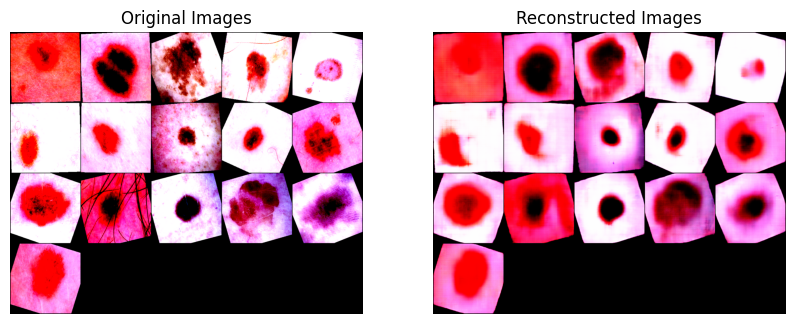

Epoch 5, Final Loss: 0.9932454484529769
Epoch 6, Final Loss: 1.0110728595965206
Epoch 7, Final Loss: 0.914019170374916
Epoch 8, Final Loss: 0.9305193569903938


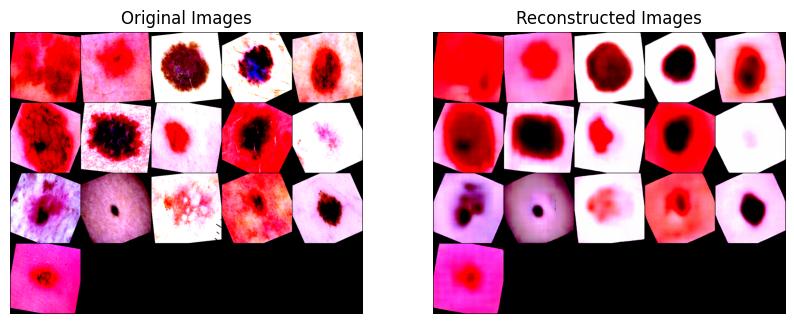

Epoch 9, Final Loss: 0.9297709869690978
Epoch 10, Final Loss: 0.9174089998292466
Epoch 11, Final Loss: 0.8951883549317003
Epoch 12, Final Loss: 0.8766591135686198


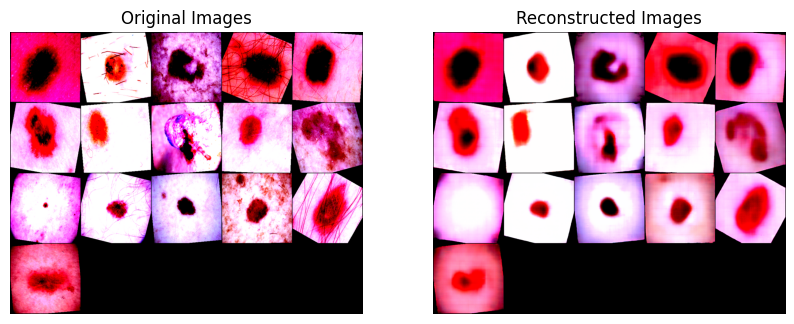

Epoch 13, Final Loss: 0.8737375462969271
Epoch 14, Final Loss: 0.8624498229057264
Epoch 15, Final Loss: 0.8501016872759444
Epoch 16, Final Loss: 0.8611049817773861


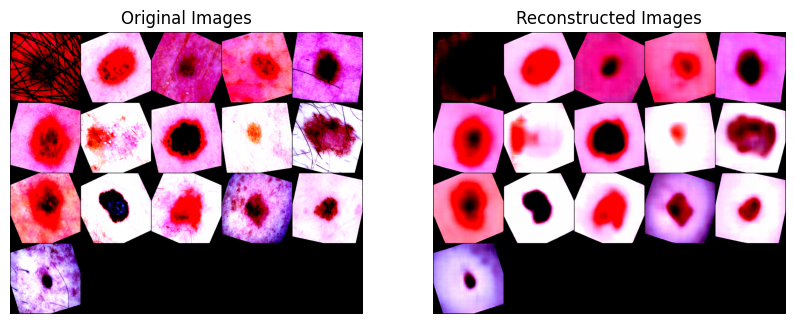

Epoch 17, Final Loss: 0.8353707611370391
Epoch 18, Final Loss: 0.8398371010352248
Epoch 19, Final Loss: 0.8293036749949471
Epoch 20, Final Loss: 0.8286889679134845


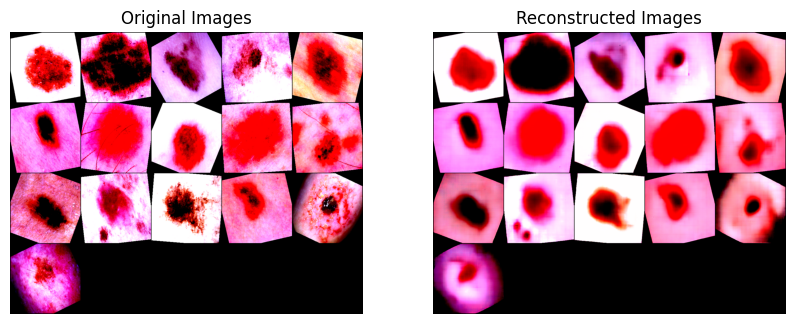

In [19]:
# Train VQ-VAE model with WandB logging
train_vq_vae_wandb(vq_vae_model, optimizer, train_loader, project_name="Dl_assignment_5", entity="m23csa004")

In [20]:
# Step 2: Process the entire training dataset via the encoder
def encode_dataset(encoder, data_loader):
    encoded_data = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            encoded_images = vq_vae_model.encoder(data)
            q,_, indices = vq_vae_model.vq_layer(encoded_images)
            #print(indices.shape)
            indices = indices.view(-1,1,16,16)
            encoded_data.append(indices)
            
    return torch.cat(encoded_data)

In [21]:
# Step 3: Create a new dataset with code indices
class EncodedDataset(torch.utils.data.Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return self.encoded_data[idx]

In [22]:
encoded_data = encode_dataset(vq_vae_model, train_loader)
encoded_dataset = EncodedDataset(encoded_data)
encoded_loader = DataLoader(encoded_dataset, batch_size=16, shuffle=True)

In [23]:
print(encoded_data.shape)

torch.Size([10015, 1, 16, 16])


In [24]:
import torch.nn as nn
import torch


class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        # _, depth, height, width = self.weight.size()
        h, w = kernel_size, kernel_size

        if mask_type == 'A':
            self.mask[:, :, h // 2, w // 2:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0
        else:
            self.mask[:, :, h // 2, w // 2 + 1:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [25]:
class ResidualMaskedConv2d(nn.Module):
    """
    Residual Links between MaskedConv2d-layers
    As described in Figure 5 in "Pixel Recurrent Neural Networks" by Aaron van den Oord et. al.
    """

    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            MaskedConv2d('B', in_dim, in_dim // 2, kernel_size=1, padding=0),
            nn.ReLU(),
            MaskedConv2d('B', in_dim // 2, in_dim // 2, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_dim // 2, in_dim, kernel_size=1, padding=0),
            nn.ReLU())

    def forward(self, x):
        return self.net(x) + x

In [26]:
class PixelRCNN(nn.Module):
    """
    Pixel R-CNN-class that assumes color channels as independent using residual blocks
    from "Pixel Recurrent Neural Networks" by Aaron van den Oord et. al.
    """

    def __init__(self, in_channels, out_channels, conv_filters):
        super().__init__()
        self.net = nn.Sequential(
            # A 7x7 A-type convolution with batch norm
            MaskedConv2d('A', in_channels, conv_filters, kernel_size=7, padding=3),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            # 8 Residual B-type convolutons with batch norms
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            ResidualMaskedConv2d(conv_filters),
            nn.BatchNorm2d(conv_filters),
            nn.ReLU(),
            MaskedConv2d('B', conv_filters, out_channels, kernel_size=1)).cuda()
        
    def forward(self, x):
        return self.net(x)

   

In [27]:
# H, W, C = 8,8,256
# no_channels, out_channels, convolution_filters = 256, 256, 120

H, W, C = 16,16,1
no_channels, out_channels, convolution_filters = 1, 512, 120

pixelrcnn = PixelRCNN(no_channels, out_channels, convolution_filters).cuda()

In [28]:
# Print the model summary
summary(pixelrcnn, (no_channels, H, W))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      MaskedConv2d-1          [-1, 120, 16, 16]           6,000
       BatchNorm2d-2          [-1, 120, 16, 16]             240
              ReLU-3          [-1, 120, 16, 16]               0
      MaskedConv2d-4           [-1, 60, 16, 16]           7,260
              ReLU-5           [-1, 60, 16, 16]               0
      MaskedConv2d-6           [-1, 60, 16, 16]         176,460
              ReLU-7           [-1, 60, 16, 16]               0
      MaskedConv2d-8          [-1, 120, 16, 16]           7,320
              ReLU-9          [-1, 120, 16, 16]               0
ResidualMaskedConv2d-10          [-1, 120, 16, 16]               0
      BatchNorm2d-11          [-1, 120, 16, 16]             240
             ReLU-12          [-1, 120, 16, 16]               0
     MaskedConv2d-13           [-1, 60, 16, 16]           7,260
             ReLU-14           [-1, 

In [29]:
# def train_pixelrcnn():
    

#     n_epochs = 100
#     lr = 1e-3
    
#     train_loader = encoded_loader
#     optimizer = torch.optim.Adam(pixelrcnn.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()

#     train_losses = []
    

#     for epoch in range(n_epochs):
#         for batch_x in train_loader:
#             optimizer.zero_grad()
#             modified_batch_x = batch_x.float()
#             modified_batch_x = modified_batch_x.to(device)
#             batch_x = batch_x.to(device)
#             #output = pixelrcnn(normalize(batch_x))
#             output = pixelrcnn(modified_batch_x)
            
#             output = output.permute(0, 2, 3, 1).contiguous().view(-1,512)
#             #print(output.shape)
#             batch_x = batch_x.view(-1)
            
#              #print(output.shape)
#             #loss = cross_entropy_loss(batch_x, output)
#             loss = criterion(output,batch_x)
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         epoch_loss = sum(train_losses[-len(train_loader):]) / len(train_loader)
#         print(f"[{100*(epoch+1)/n_epochs:.2f}%] Epoch {epoch + 1}")
#         print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}")
#     torch.cuda.empty_cache()


In [30]:
# train_pixelrcnn()

**Run with wandb logs and save the weights**

In [31]:
# Directory to save model weights
weights_dir = "./dl_assignment5/weights_PixelRCNN_final1"

# Change the directory to save the weights within Kaggle's working directory
weights_dir_kaggle = "/kaggle/working" + weights_dir[1:]

# Ensure the directory exists or create it
if not os.path.exists(weights_dir_kaggle):
    os.makedirs(weights_dir_kaggle)


In [32]:
def train_pixelrcnn(project_name="Dl_assignment_5_pixelcnn", entity="m23csa004"):
    wandb.init(project=project_name, entity=entity)

    n_epochs = 100
    lr = 1e-3

    train_loader = encoded_loader
    optimizer = torch.optim.Adam(pixelrcnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []

    for epoch in range(n_epochs):
        for batch_x in train_loader:
            optimizer.zero_grad()
            modified_batch_x = batch_x.float()
            modified_batch_x = modified_batch_x.to(device)
            batch_x = batch_x.to(device)
            output = pixelrcnn(modified_batch_x)

            output = output.permute(0, 2, 3, 1).contiguous().view(-1, 512)
            batch_x = batch_x.view(-1)

            loss = criterion(output, batch_x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # Log loss to WandB
            wandb.log({"Training Loss": loss.item()})

        epoch_loss = sum(train_losses[-len(train_loader):]) / len(train_loader)
        print(f"[{100*(epoch+1)/n_epochs:.2f}%] Epoch {epoch + 1}")
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}")

    torch.cuda.empty_cache()



In [33]:
# Train PixelRCNN model with WandB logging
train_pixelrcnn()


# Save model weights
torch.save(pixelrcnn.state_dict(), os.path.join(weights_dir_kaggle, "pixelrcnn_weights.pth"))

[1.00%] Epoch 1
Epoch [1/100], Loss: 1.2642
[2.00%] Epoch 2
Epoch [2/100], Loss: 0.8462
[3.00%] Epoch 3
Epoch [3/100], Loss: 0.8029
[4.00%] Epoch 4
Epoch [4/100], Loss: 0.7753
[5.00%] Epoch 5
Epoch [5/100], Loss: 0.7549
[6.00%] Epoch 6
Epoch [6/100], Loss: 0.7384
[7.00%] Epoch 7
Epoch [7/100], Loss: 0.7233
[8.00%] Epoch 8
Epoch [8/100], Loss: 0.7099
[9.00%] Epoch 9
Epoch [9/100], Loss: 0.6978
[10.00%] Epoch 10
Epoch [10/100], Loss: 0.6868
[11.00%] Epoch 11
Epoch [11/100], Loss: 0.6768
[12.00%] Epoch 12
Epoch [12/100], Loss: 0.6677
[13.00%] Epoch 13
Epoch [13/100], Loss: 0.6588
[14.00%] Epoch 14
Epoch [14/100], Loss: 0.6507
[15.00%] Epoch 15
Epoch [15/100], Loss: 0.6438
[16.00%] Epoch 16
Epoch [16/100], Loss: 0.6365
[17.00%] Epoch 17
Epoch [17/100], Loss: 0.6302
[18.00%] Epoch 18
Epoch [18/100], Loss: 0.6247
[19.00%] Epoch 19
Epoch [19/100], Loss: 0.6192
[20.00%] Epoch 20
Epoch [20/100], Loss: 0.6137
[21.00%] Epoch 21
Epoch [21/100], Loss: 0.6091
[22.00%] Epoch 22
Epoch [22/100], Loss: 

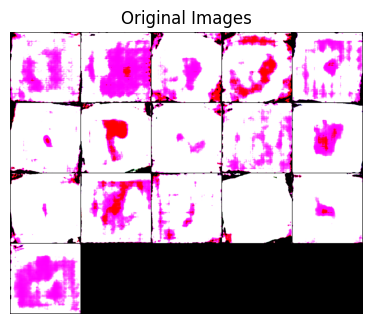

In [34]:

from torchvision.utils import make_grid
samples = torch.zeros(size=(16, C, H, W)).cuda()


# Iterate over each element in the 8x8 grid
for i in range(16):
    for j in range(16):
        # Get logits for the current state of the image
        logits = pixelrcnn(samples.float())  # Ensure input is float
        #print(logits.shape)
        # Get probabilities from logits
        probabilities = torch.softmax(logits[:, :, i, j], dim=1)
        # Sample from the probabilities to get the next index
        new_index = torch.multinomial(probabilities, num_samples=1)  # Sampling from the categorical distribution
        # Place the sampled index in the correct location
        samples[:, :, i, j] = new_index
        #print(samples.shape)

#out = pixelrcnn(samples)
out = torch.round(samples).to(torch.int64)
encoding_indices = out.view(4096,1)
#print(encoding_indices)
encodings = torch.zeros(4096, vq_vae_model.vq_layer.num_embeddings).to(device)

encodings.scatter_(1, encoding_indices, 1)
#print(encodings)
quantized = torch.matmul(encodings, vq_vae_model.vq_layer.embedding.weight).view(16,256,8,8)
#print(quantized)
generated_images = vq_vae_model.decoder(quantized)


#generated_images = generated_images.to('cpu').detach().numpy()
generated_images = (generated_images - generated_images.min()) / (generated_images.max() - generated_images.min()) * 255


def show_samples(samples, nrow=16, title='Samples'):
    original_image = torchvision.utils.make_grid(samples.cpu(), nrow=5)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Images')
    plt.imshow(original_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    
show_samples(generated_images, nrow=16, title='Samples')

In [35]:

# from torchvision.utils import make_grid
# samples = torch.zeros(size=(16, C, H, W)).cuda()

# pixelrcnn.eval()

# out = pixelrcnn(samples)
# out = torch.round(out).to(torch.int64)
# encoding_indices = out.view(4096,1)
# #print(encoding_indices)
# encodings = torch.zeros(4096, vq_vae_model.vq_layer.num_embeddings).to(device)

# encodings.scatter_(1, encoding_indices, 1)
# #print(encodings)
# quantized = torch.matmul(encodings, vq_vae_model.vq_layer.embedding.weight).view(16,256,8,8)
# #print(quantized)
# generated_images = vq_vae_model.decoder(quantized)

# def show_samples(samples, nrow=16, title='Samples'):
#     original_image = torchvision.utils.make_grid(samples.cpu(), nrow=5)
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.title('Original Images')
#     plt.imshow(original_image.permute(1, 2, 0))
#     plt.axis('off')
#     plt.show()
    
    
# show_samples(generated_images, nrow=16, title='Samples')